In [97]:
import numpy as np
import pandas as pd
import csv
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind, ttest_rel

In [57]:
"""Pareto smoothed importance sampling (PSIS)

This module implements Pareto smoothed importance sampling (PSIS) and PSIS
leave-one-out (LOO) cross-validation for Python (Numpy).

Included functions
------------------
psisloo
    Pareto smoothed importance sampling leave-one-out log predictive densities.

psislw
    Pareto smoothed importance sampling.

gpdfitnew
    Estimate the paramaters for the Generalized Pareto Distribution (GPD).

gpinv
    Inverse Generalised Pareto distribution function.

sumlogs
    Sum of vector where numbers are represented by their logarithms.

References
----------
Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Practical
Bayesian model evaluation using leave-one-out cross-validation
and WAIC. Statistics and Computing, 27(5):1413–1432.
doi:10.1007/s11222-016-9696-4. https://arxiv.org/abs/1507.04544

Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Pareto
smoothed importance sampling. https://arxiv.org/abs/arXiv:1507.02646v5

"""

from __future__ import division # For Python 2 compatibility
import numpy as np

# 3-Clause BSD License
"""
Copyright 2017 Aki Vehtari, Tuomas Sivula

Redistribution and use in source and binary forms, with or without modification,
are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
this list of conditions and the following disclaimer in the documentation and/or
other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors
may be used to endorse or promote products derived from this software without
specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON
ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. """


def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.

    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).

    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).

    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.

    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities

    loos : ndarray
        individual leave-one-out log predictive density terms

    ks : ndarray
        estimated Pareto tail indeces

    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    return loo, loos, ks


def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).

    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.

    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``

    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.

    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices

    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss


def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)

    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.

    Parameters
    ----------
    x : ndarray
        One dimensional data array

    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.

    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).

    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.

    Returns
    -------
    k, sigma : float
        estimated parameter values

    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.

    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.

    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        return k, sigma, ks, w
    else:
        return k, sigma


def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x


def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.

    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.

    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out

In [58]:
subject_num = 62
def read_data(n):
    #数据文件在的位置
    action = []
    reward = []
    reward_B = []
    comparision = [] #r-r_b; 1:>=0, 0:<0
    # num = str(220+n)
    SUB = [1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,
                50,51,52,53,54,55,56,57,58,59,60,61,62,63,64]
    num = str(220+SUB[n])
    file = pd.read_csv('E:/multi-bandit/task2v3/RLE2V3_data/' + num + '.csv')
    name = 'sub (' +str(n) +').csv'
    action_index = 0
    for i in  range((file.shape[1])):
        if file.columns[i] == 'choose_bandit.keys':
            action_index = i
    reward_index = 0
    for i in  range((file.shape[1])):
        if file.columns[i] == 'subchoose':
            reward_index = i
    for i in range((file.shape[0])):

        if (file.iloc[i,0] == 1 or file.iloc[i,0] == 0) and file.iloc[i,action_index]!='None' :
            if file.iloc[i,action_index] == 'r':
                action.append(0)
            elif file.iloc[i,action_index] == 'f':
                action.append(1)
            elif file.iloc[i,action_index] == 'i':
                action.append(2)
            elif file.iloc[i,action_index] == 'j':
                action.append(3)
            else:
                print(file.iloc[i,action_index])
                print(i)
                raise ValueError('不能识别选项')
            if int(file.iloc[i,reward_index])>100:
                reward.append(100)
            elif int(file.iloc[i,reward_index])<0:
                reward.append(0)
            else:
                reward.append(int(file.iloc[i,reward_index]))

            if int(file.iloc[i,reward_index+1])>100:
                reward_B.append(100)
            elif int(file.iloc[i,reward_index+1])<0:
                reward_B.append(0)
            else:
                reward_B.append(int(file.iloc[i,reward_index+1]))
            if int(file.iloc[i,reward_index]) >= int(file.iloc[i,reward_index+1]):
                comparision.append(int(file.iloc[i,reward_index])-int(file.iloc[i,reward_index+1]))
            else:
                comparision.append(int(file.iloc[i,reward_index+1])-int(file.iloc[i,reward_index]))
        elif (file.iloc[i,0] == 1 or file.iloc[i,0] == 0)  and file.iloc[i,action_index] =='None' :
            action.append(4)
            reward.append(0)
            reward_B.append(0)
            comparision.append(0)
    return action,reward,reward_B,comparision


In [59]:
def read_parameter_1_para(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta = []
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    beta = np.array(beta)
    return beta

def read_parameter_2_para(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta = []
    phi = []
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi.append(parameter_result.iloc[i+subject_num,1])
    beta = np.array(beta)
    phi = np.array(phi)
    return beta,phi

def read_parameter_3_para(file_name):
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    para1 = []
    para2 = []
    para3 = []
    for i in range(subject_num):
        para1.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        para2.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        para3.append(parameter_result.iloc[i+subject_num*2,1])
    para1 = np.array(para1)
    para2 = np.array(para2)
    para3 = np.array(para3)
    return para1,para2,para3

def read_parameter_4_para(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta = []
    phi = []
    persev = []
    gamma = []
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma.append(parameter_result.iloc[i+subject_num*3,1])
    beta = np.array(beta)
    phi = np.array(phi)
    persev = np.array(persev)
    gamma = np.array(gamma)
    return beta,phi,persev,gamma

def read_parameter_5_para(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta_a = []
    phi_a = []
    persev_a = []
    gamma_a = []
    beta_b = []


    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*4,1])


    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)
    gamma_a = np.array(gamma_a)
    beta_b = np.array(beta_b)


    return beta_a,phi_a,persev_a,gamma_a,beta_b

def read_parameter_6_para(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta_a = []
    phi_a = []
    persev_a = []

    beta_b = []
    phi_b = []
    persev_b = []

    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])

    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*5,1])

    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)

    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)

    return beta_a,phi_a,persev_a,beta_b,phi_b,persev_b

def read_parameter_7_para(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta_a = []
    phi_a = []
    persev_a = []
    gamma_a = []
    beta_b = []
    phi_b = []
    persev_b = []

    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*6,1])

    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)
    gamma_a = np.array(gamma_a)
    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)

    return beta_a,phi_a,persev_a,gamma_a,beta_b,phi_b,persev_b

def read_parameter_8_para(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta_a = []
    phi_a = []
    persev_a = []
    gamma_a = []
    beta_b = []
    phi_b = []
    persev_b = []
    gamma_b = []
    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*6,1])
    for i in range(subject_num):
        gamma_b.append(parameter_result.iloc[i+subject_num*7,1])
    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)
    gamma_a = np.array(gamma_a)
    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)
    gamma_b = np.array(gamma_b)
    return beta_a,phi_a,persev_a,gamma_a,beta_b,phi_b,persev_b,gamma_b

def read_parameter_9_para(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta_a_0 = []
    phi_a_0 = []
    persev_a_0 = []
    gamma_a_0 = []
    
    beta_a_1 = []
    phi_a_1 = []
    persev_a_1 = []
    gamma_a_1 = []
    
    beta_b = []

    for i in range(subject_num):
        beta_a_0.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a_0.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a_0.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a_0.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_a_1.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_a_1.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_a_1.append(parameter_result.iloc[i+subject_num*6,1])
    for i in range(subject_num):
        gamma_a_1.append(parameter_result.iloc[i+subject_num*7,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*8,1])

        
    beta_a_0 = np.array(beta_a_0)
    phi_a_0 = np.array(phi_a_0)
    persev_a_0 = np.array(persev_a_0)
    gamma_a_0 = np.array(gamma_a_0)
    
    beta_a_1 = np.array(beta_a_1)
    phi_a_1 = np.array(phi_a_1)
    persev_a_1 = np.array(persev_a_1)
    gamma_a_1 = np.array(gamma_a_1)
    
    beta_b = np.array(beta_b)

    return beta_a_0,phi_a_0,persev_a_0,gamma_a_0,beta_a_1,phi_a_1,persev_a_1,gamma_a_1,beta_b

def read_parameter_12_para(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta_a_0 = []
    phi_a_0 = []
    persev_a_0 = []
    gamma_a_0 = []
    
    beta_a_1 = []
    phi_a_1 = []
    persev_a_1 = []
    gamma_a_1 = []
    
    beta_b = []
    phi_b = []
    persev_b = []
    gamma_b = []
    for i in range(subject_num):
        beta_a_0.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a_0.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a_0.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a_0.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_a_1.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_a_1.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_a_1.append(parameter_result.iloc[i+subject_num*6,1])
    for i in range(subject_num):
        gamma_a_1.append(parameter_result.iloc[i+subject_num*7,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*8,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*9,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*10,1])
    for i in range(subject_num):
        gamma_b.append(parameter_result.iloc[i+subject_num*11,1])
        
    beta_a_0 = np.array(beta_a_0)
    phi_a_0 = np.array(phi_a_0)
    persev_a_0 = np.array(persev_a_0)
    gamma_a_0 = np.array(gamma_a_0)
    
    beta_a_1 = np.array(beta_a_1)
    phi_a_1 = np.array(phi_a_1)
    persev_a_1 = np.array(persev_a_1)
    gamma_a_1 = np.array(gamma_a_1)
    
    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)
    gamma_b = np.array(gamma_b)
    return beta_a_0,phi_a_0,persev_a_0,gamma_a_0,beta_a_1,phi_a_1,persev_a_1,gamma_a_1,beta_b,phi_b,persev_b,gamma_b



In [60]:
def read_parameter_1_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta = []
    beta_sd = []
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        beta_sd.append(parameter_result.iloc[i,3])
    beta = np.array(beta)
    beta_sd = np.array(beta_sd)
    return beta,beta_sd

def read_parameter_2_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta = []
    phi = []
    
    beta_sd = []
    phi_sd = []
    
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi.append(parameter_result.iloc[i+subject_num,1])
        
    for i in range(subject_num):
        beta_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_sd.append(parameter_result.iloc[i+subject_num,3])
        
    beta = np.array(beta)
    phi = np.array(phi)
    
    beta_sd = np.array(beta_sd)
    phi_sd = np.array(phi_sd)
    
    return beta,phi,beta_sd,phi_sd

def read_parameter_3_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta = []
    phi = []
    persev = []
    
    beta_sd = []
    phi_sd = []
    persev_sd = []
    
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev.append(parameter_result.iloc[i+subject_num*2,1])
        
    for i in range(subject_num):
        beta_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_sd.append(parameter_result.iloc[i+subject_num*2,3])
        
    beta_sd = np.array(beta_sd)
    phi_sd = np.array(phi_sd)
    persev_sd = np.array(persev_sd)
    
    beta = np.array(beta)
    phi = np.array(phi)
    persev = np.array(persev)
    
    return beta,phi,persev,beta_sd,phi_sd,persev_sd

def read_parameter_4_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta = []
    phi = []
    persev = []
    gamma = []
    
    beta_sd = []
    phi_sd = []
    persev_sd = []
    gamma_sd = []
    
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma.append(parameter_result.iloc[i+subject_num*3,1])
        
    for i in range(subject_num):
        beta_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_sd.append(parameter_result.iloc[i+subject_num*2,3])
    for i in range(subject_num):
        gamma_sd.append(parameter_result.iloc[i+subject_num*3,3])
    
    beta = np.array(beta)
    phi = np.array(phi)
    persev = np.array(persev)
    gamma = np.array(gamma)
    
    beta_sd = np.array(beta_sd)
    phi_sd = np.array(phi_sd)
    persev_sd = np.array(persev_sd)
    gamma_sd = np.array(gamma_sd)
    
    return beta,phi,persev,gamma,beta_sd,phi_sd,persev_sd,gamma_sd

def read_parameter_5_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta_a = []
    phi_a = []
    persev_a = []
    gamma_a = []
    beta_b = []
    
    beta_a_sd = []
    phi_a_sd = []
    persev_a_sd = []
    gamma_a_sd = []
    beta_b_sd = []

    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*4,1])
        
    for i in range(subject_num):
        beta_a_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_a_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_a_sd.append(parameter_result.iloc[i+subject_num*2,3])
    for i in range(subject_num):
        gamma_a_sd.append(parameter_result.iloc[i+subject_num*3,3])
    for i in range(subject_num):
        beta_b_sd.append(parameter_result.iloc[i+subject_num*4,3])

    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)
    gamma_a = np.array(gamma_a)
    beta_b = np.array(beta_b)
    
    beta_a_sd = np.array(beta_a_sd)
    phi_a_sd = np.array(phi_a_sd)
    persev_a_sd = np.array(persev_a_sd)
    gamma_a_sd = np.array(gamma_a_sd)
    beta_b_sd = np.array(beta_b_sd)

    return beta_a,phi_a,persev_a,gamma_a,beta_b,beta_a_sd,phi_a_sd,persev_a_sd,gamma_a_sd,beta_b_sd

def read_parameter_6_para_sample(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta_a = []
    phi_a = []
    persev_a = []

    beta_b = []
    phi_b = []
    persev_b = []
    
    beta_a_sd = []
    phi_a_sd = []
    persev_a_sd = []

    beta_b_sd = []
    phi_b_sd = []
    persev_b_sd = []

    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])

    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*5,1])
        
    for i in range(subject_num):
        beta_a_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_a_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_a_sd.append(parameter_result.iloc[i+subject_num*2,3])

    for i in range(subject_num):
        beta_b_sd.append(parameter_result.iloc[i+subject_num*3,3])
    for i in range(subject_num):
        phi_b_sd.append(parameter_result.iloc[i+subject_num*4,3])
    for i in range(subject_num):
        persev_b_sd.append(parameter_result.iloc[i+subject_num*5,3])

    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)

    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)
    
    beta_a_sd = np.array(beta_a_sd)
    phi_a_sd = np.array(phi_a_sd)
    persev_a_sd = np.array(persev_a_sd)

    beta_b_sd = np.array(beta_b_sd)
    phi_b_sd = np.array(phi_b_sd)
    persev_b_sd = np.array(persev_b_sd)

    return beta_a,phi_a,persev_a,beta_b,phi_b,persev_b,beta_a_sd,phi_a_sd,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd

def read_parameter_7_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta_a = []
    phi_a = []
    persev_a = []
    gamma_a = []
    beta_b = []
    phi_b = []
    persev_b = []
    
    beta_a_sd = []
    phi_a_sd = []
    persev_a_sd = []
    gamma_a_sd = []
    beta_b_sd = []
    phi_b_sd = []
    persev_b_sd = []

    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*6,1])
        
    for i in range(subject_num):
        beta_a_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_a_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_a_sd.append(parameter_result.iloc[i+subject_num*2,3])
    for i in range(subject_num):
        gamma_a_sd.append(parameter_result.iloc[i+subject_num*3,3])
    for i in range(subject_num):
        beta_b_sd.append(parameter_result.iloc[i+subject_num*4,3])
    for i in range(subject_num):
        phi_b_sd.append(parameter_result.iloc[i+subject_num*5,3])
    for i in range(subject_num):
        persev_b_sd.append(parameter_result.iloc[i+subject_num*6,3])

    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)
    gamma_a = np.array(gamma_a)
    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)
    
    beta_a_sd = np.array(beta_a_sd)
    phi_a_sd = np.array(phi_a_sd)
    persev_a_sd = np.array(persev_a_sd)
    gamma_a_sd = np.array(gamma_a_sd)
    beta_b_sd = np.array(beta_b_sd)
    phi_b_sd = np.array(phi_b_sd)
    persev_b_sd = np.array(persev_b_sd)

    return beta_a,phi_a,persev_a,gamma_a,beta_b,phi_b,persev_b,beta_a_sd,phi_a_sd,persev_a_sd,gamma_a_sd,beta_b_sd,phi_b_sd,persev_b_sd

def read_parameter_9_para_sample(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 62
    beta_a_0 = []
    phi_a_0 = []
    persev_a_0 = []
    gamma_a_0 = []
    beta_a_1 = []
    phi_a_1 = []
    persev_a_1 = []
    gamma_a_1 = []
    beta_b = []
    
    beta_a_0_sd = []
    phi_a_0_sd = []
    persev_a_0_sd = []
    gamma_a_0_sd = []
    beta_a_1_sd = []
    phi_a_1_sd = []
    persev_a_1_sd = []
    gamma_a_1_sd = []
    beta_b_sd = []

    for i in range(subject_num):
        beta_a_0.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a_0.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a_0.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a_0.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_a_1.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_a_1.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_a_1.append(parameter_result.iloc[i+subject_num*6,1])
    for i in range(subject_num):
        gamma_a_1.append(parameter_result.iloc[i+subject_num*7,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*8,1])
        
    for i in range(subject_num):
        beta_a_0_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_a_0_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_a_0_sd.append(parameter_result.iloc[i+subject_num*2,3])
    for i in range(subject_num):
        gamma_a_0_sd.append(parameter_result.iloc[i+subject_num*3,3])
    for i in range(subject_num):
        beta_a_1_sd.append(parameter_result.iloc[i+subject_num*4,3])
    for i in range(subject_num):
        phi_a_1_sd.append(parameter_result.iloc[i+subject_num*5,3])
    for i in range(subject_num):
        persev_a_1_sd.append(parameter_result.iloc[i+subject_num*6,3])
    for i in range(subject_num):
        gamma_a_1_sd.append(parameter_result.iloc[i+subject_num*7,3])
    for i in range(subject_num):
        beta_b_sd.append(parameter_result.iloc[i+subject_num*8,3])

        
    beta_a_0 = np.array(beta_a_0)
    phi_a_0 = np.array(phi_a_0)
    persev_a_0 = np.array(persev_a_0)
    gamma_a_0 = np.array(gamma_a_0)
    beta_a_1 = np.array(beta_a_1)
    phi_a_1 = np.array(phi_a_1)
    persev_a_1 = np.array(persev_a_1)
    gamma_a_1 = np.array(gamma_a_1)
    beta_b = np.array(beta_b)
    
    beta_a_0_sd = np.array(beta_a_0_sd)
    phi_a_0_sd = np.array(phi_a_0_sd)
    persev_a_0_sd = np.array(persev_a_0_sd)
    gamma_a_0_sd = np.array(gamma_a_0_sd)
    beta_a_1_sd = np.array(beta_a_1_sd)
    phi_a_1_sd = np.array(phi_a_1_sd)
    persev_a_1_sd = np.array(persev_a_1_sd)
    gamma_a_1_sd = np.array(gamma_a_1_sd)
    beta_b_sd = np.array(beta_b_sd)

    return beta_a_0,phi_a_0,persev_a_0,gamma_a_0,beta_a_1,phi_a_1,persev_a_1,gamma_a_1,beta_b,beta_a_0_sd,phi_a_0_sd,persev_a_0_sd,gamma_a_0_sd,beta_a_1_sd,phi_a_1_sd,persev_a_1_sd,gamma_a_1_sd,beta_b_sd



In [61]:
def action_probability(Q,action):
    return np.log(np.exp(Q[action])/(np.exp(Q[0])+np.exp(Q[1])+np.exp(Q[2])+np.exp(Q[3])))

def rewards2comparison_sqrt(action,reward,reward_B,gamma):
    comparison = []
    com = 0
    for i in range(len(action)):
        if action[i]!=4:
            if com<0:
                comparison.append(-np.sqrt(-com))
            else:
                comparison.append(np.sqrt(com))
            com = reward[i] - reward_B[i] + gamma*com
        else:
            comparison.append(0)
            com = gamma*com
    return comparison

In [128]:

def llh_vep(file_name):#nhb
    beta_b,phi_b,persev_b = read_parameter_3_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_ve(file_name):#nhb
    beta_b,phi_b = read_parameter_2_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_vp(file_name):#nhb
    beta_b,persev_b = read_parameter_2_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_v(file_name):#nhb
    beta_b = read_parameter_1_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood


def llh_glm_vep(file_name):
    beta_a,phi_a,persev_a,beta_b,phi_b,persev_b = read_parameter_6_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_a[s]*comparision[t]+beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_ve(file_name):
    beta_a,phi_a,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_a[s]*comparision[t]+beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_vp(file_name):
    beta_a,persev_a,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_a[s]*comparision[t]+beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_ep(file_name):
    phi_a,persev_a,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_v(file_name):#nhb
    beta_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_a[s]*comparision[t]+beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_e(file_name):#nhb
    phi_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_p(file_name):#nhb
    persev_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_s(file_name):#nhb
    comparison_level,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                compare = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_b[s])
                        compare[action[t-1]] = comparision[t]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*(v+comparison_level[s]*compare)+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_v10(file_name):
    beta_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_a[s]*comparision[t]+beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_e10(file_name):
    phi_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_p10(file_name):
    persev_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood



def llh_glm2_vep(file_name):
    beta_a_1,phi_a_1,persev_a_1,beta_a_0,phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_9_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                else:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_ep(file_name):
    phi_a_1,persev_a_1,phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_7_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                else:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v(file_name):
    beta_a_1,beta_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                elif comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e(file_name):
    phi_a_1,phi_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                elif comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_p(file_name):
    persev_a_1,persev_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                elif comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood


def llh_glm2_v1e1p1(file_name):
    beta_a_1,phi_a_1,persev_a_1,beta_b,phi_b,persev_b = read_parameter_6_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v0e0p0(file_name):
    beta_a_0,phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_6_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v1e1p0(file_name):
    beta_a_1,phi_a_1,persev_a_0,beta_b,phi_b,persev_b = read_parameter_6_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood


def llh_glm2_v1e1(file_name):
    beta_a_1,phi_a_1,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v1p1(file_name):
    beta_a_1,persev_a_1,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e1p1(file_name):
    phi_a_1,persev_a_1,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v0e0(file_name):
    beta_a_0,phi_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v0p0(file_name):
    beta_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e0p0(file_name):
    phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood


def llh_glm2_v1(file_name):
    beta_a_1,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v0(file_name):
    beta_a_0,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e1(file_name):
    phi_a_1,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e0(file_name):
    phi_a_0,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_p1(file_name):
    persev_a_1,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_p0(file_name):
    persev_a_0,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e1p(file_name):
    phi_a_1,persev_a,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 62
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood




In [129]:

def loo_vep(file_name):#nhb
    beta_b_mean,phi_b_mean,persev_b_mean,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_3_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = phi_b[s] * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_b[s]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_ve(file_name):#nhb
    beta_b_mean,phi_b_mean,beta_b_sd,phi_b_sd = read_parameter_2_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = phi_b[s] * re_sig

                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v+eb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_vp(file_name):#nhb
    beta_b_mean,persev_b_mean,beta_b_sd,persev_b_sd = read_parameter_2_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)

        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig

                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_b[s]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_v(file_name):#nhb
    beta_b_mean,beta_b_sd = read_parameter_1_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration

                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo



def loo_glm_vep(file_name):
    beta_a_mean,phi_a_mean,persev_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_sd,phi_a_sd,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_6_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_a = np.random.normal(beta_a_mean[i], beta_a_sd[i], size=sample_num)
        phi_a = np.random.normal(phi_a_mean[i], phi_a_sd[i], size=sample_num)
        persev_a = np.random.normal(persev_a_mean[i], persev_a_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a[s]*comparision[t]+beta_b[s]
                    if beta_t<0:
                        beta_t = 0
                    sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_ve(file_name):
    beta_a_mean,phi_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_sd,phi_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_a = np.random.normal(beta_a_mean[i], beta_a_sd[i], size=sample_num)
        phi_a = np.random.normal(phi_a_mean[i], phi_a_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a[s]*comparision[t]+beta_b[s]
                    if beta_t<0:
                        beta_t = 0
                    sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_vp(file_name):
    beta_a_mean,persev_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_sd,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_a = np.random.normal(beta_a_mean[i], beta_a_sd[i], size=sample_num)
        persev_a = np.random.normal(persev_a_mean[i], persev_a_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a[s]*comparision[t]+beta_b[s]
                    if beta_t<0:
                        beta_t = 0
                    sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_ep(file_name):
    phi_a_mean,persev_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_sd,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):

        phi_a = np.random.normal(phi_a_mean[i], phi_a_sd[i], size=sample_num)
        persev_a = np.random.normal(persev_a_mean[i], persev_a_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t<0:
                        beta_t = 0
                    sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_v(file_name):#nhb
    beta_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_a = np.random.normal(beta_a_mean[i], beta_a_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = phi_b[s] * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_b[s]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a[s]*comparision[t]+beta_b[s]
                    if beta_t<0:
                        beta_t = 0
                    sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_e(file_name):#nhb
    phi_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        phi_a = np.random.normal(phi_a_mean[i], phi_a_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_b[s]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_p(file_name):#nhb
    persev_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        persev_a = np.random.normal(persev_a_mean[i], persev_a_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = phi_b[s] * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_a[s]*comparision[t]+persev_b[s]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_s(file_name):#nhb
    comparison_level_mean,beta_b_mean,phi_b_mean,persev_b_mean,comparison_level_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        comparison_level = np.random.normal(comparison_level_mean[i], comparison_level_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = phi_b[s] * re_sig
                    pb = np.zeros((4))
                    compare = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_b[s]
                            compare[action[t-1]] = comparision[t]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*(v+comparison_level[s]*compare)+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo


def loo_glm2_vep(file_name):
    beta_a_1_mean,phi_a_1_mean,persev_a_1_mean,beta_a_0_mean,phi_a_0_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,phi_a_1_sd,persev_a_1_sd,beta_a_0_sd,phi_a_0_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_9_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)
        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)
        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)
        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)
        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_ep(file_name):
    phi_a_1_mean,persev_a_1_mean,phi_a_0_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_1_sd,persev_a_1_sd,phi_a_0_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_7_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)

        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)
        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v10(file_name):
    beta_a_1_mean,beta_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,beta_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)

        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e10(file_name):
    phi_a_1_mean,phi_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_1_sd,phi_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)

        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_p10(file_name):
    persev_a_1_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,persev_a_1_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)

        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo


def loo_glm2_v1e1p1(file_name):
    beta_a_1_mean,phi_a_1_mean,persev_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,phi_a_1_sd,persev_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_6_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)
        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)
        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v0e0p0(file_name):
    beta_a_0_mean,phi_a_0_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_0_sd,phi_a_0_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_6_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)
        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)
      
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v1e1p0(file_name):
    beta_a_1_mean,phi_a_1_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,phi_a_1_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_6_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)
        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)
        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo


def loo_glm2_v1e1(file_name):
    beta_a_1_mean,phi_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,phi_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)
        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v1p1(file_name):
    beta_a_1_mean,persev_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,persev_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)

        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e1p1(file_name):
    phi_a_1_mean,persev_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_1_sd,persev_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)
        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v0e0(file_name):
    beta_a_0_mean,phi_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_0_sd,phi_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)
        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v0p0(file_name):
    beta_a_0_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_0_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)

        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e0p0(file_name):
    phi_a_0_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_0_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo


def loo_glm2_v1(file_name):
    beta_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):


        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v0(file_name):
    beta_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)



        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e1(file_name):
    phi_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):


        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e0(file_name):
    phi_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)



        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_p1(file_name):
    persev_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,persev_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):


        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_p0(file_name):
    persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)



        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e1p(file_name):
    phi_a_1_mean,persev_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_1_sd,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 62
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)
        persev_a = np.random.normal(persev_a_mean[i], persev_a_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo



In [44]:
def calculate_bic(log_likelihood, n_params):
    return -2 * log_likelihood + n_params * np.log(9000)
def calculate_aic(log_likelihood, n_params):
    return 2 * n_params - 2 * log_likelihood

In [64]:
s_llh = llh_s('./fitting_result/model_s_exp2.csv')
print('model_s llh: ',np.sum(s_llh))

# glm2_e1p_llh = llh_glm2_e1p('./fitting_result/model_glm2_e1p_exp2.csv')
# print('model_glm2_e1p llh: ',np.sum(glm2_e1p_llh))

model_s llh:  -9927.329187322961


In [65]:
s_loo = loo_s('./fitting_result/model_s_exp2.csv')
print('model_s loo: ',np.sum(s_loo))

# glm2_e1p_loo = loo_glm2_e1p('./fitting_result/model_glm2_e1p.csv')
# print('model_glm2_e1p loo: ',np.sum(glm2_e1p_loo))

model_s loo:  -10288.48696814375


In [66]:
v_loo = loo_v('./fitting_result/model_v_exp2.csv')
print('model_v loo: ',np.sum(v_loo))

ve_loo = loo_ve('./fitting_result/model_ve_exp2.csv')
print('model_ve loo: ',np.sum(ve_loo))

vp_loo = loo_vp('./fitting_result/model_vp_exp2.csv')
print('model_vp loo: ',np.sum(vp_loo))

vep_loo = loo_vep('./fitting_result/model_vep_exp2.csv')
print('model_vep loo: ',np.sum(vep_loo))

model_v loo:  -10753.555424336024
model_ve loo:  -10354.722099567554
model_vp loo:  -10286.514549484264
model_vep loo:  -10298.245138329949


In [67]:
v_llh = llh_v('./fitting_result/model_v_exp2.csv')
print('model_v llh: ',np.sum(v_llh))

ve_llh = llh_ve('./fitting_result/model_ve_exp2.csv')
print('model_ve llh: ',np.sum(ve_llh))

vp_llh = llh_vp('./fitting_result/model_vp_exp2.csv')
print('model_vp llh: ',np.sum(vp_llh))

vep_llh = llh_vep('./fitting_result/model_vep_exp2.csv')
print('model_vep llh: ',np.sum(vep_llh))

model_v llh:  -10693.70420824784
model_ve llh:  -10176.548765822703
model_vp llh:  -10153.292125954167
model_vep llh:  -9937.52168937738


In [68]:
glm_v_loo = loo_glm_v('./fitting_result/model_glm_v_exp2.csv')
print('model_glm_v loo: ',np.sum(glm_v_loo))

glm_e_loo = loo_glm_e('./fitting_result/model_glm_e_exp2.csv')
print('model_glm_e loo: ',np.sum(glm_e_loo))

glm_p_loo = loo_glm_p('./fitting_result/model_glm_p_exp2.csv')
print('model_glm_p loo: ',np.sum(glm_p_loo))

glm_ve_loo = loo_glm_ve('./fitting_result/model_glm_ve_exp2.csv')
print('model_glm_ve loo: ',np.sum(glm_ve_loo))

glm_vp_loo = loo_glm_vp('./fitting_result/model_glm_vp_exp2.csv')
print('model_glm_vp loo: ',np.sum(glm_vp_loo))

glm_ep_loo = loo_glm_ep('./fitting_result/model_glm_ep_exp2.csv')
print('model_glm_ep loo: ',np.sum(glm_ep_loo))

glm_vep_loo = loo_glm_vep('./fitting_result/model_glm_vep_exp2.csv')
print('model_glm_vep loo: ',np.sum(glm_vep_loo))

model_glm_v loo:  -10350.07646154536
model_glm_e loo:  -10228.56700287743
model_glm_p loo:  -10221.576229095663
model_glm_ve loo:  -10444.232505929049
model_glm_vp loo:  -10338.781315313097
model_glm_ep loo:  -10495.795797716031
model_glm_vep loo:  -10742.464936466218


In [78]:
glm_v_llh = llh_glm_v('./fitting_result/model_glm_v_exp2.csv')
print('model_glm_v llh: ',np.sum(glm_v_llh))

glm_e_llh = llh_glm_e('./fitting_result/model_glm_e_exp2.csv')
print('model_glm_e llh: ',np.sum(glm_e_llh))

glm_p_llh = llh_glm_p('./fitting_result/model_glm_p_exp2.csv')
print('model_glm_p llh: ',np.sum(glm_p_llh))

glm_ve_llh = llh_glm_ve('./fitting_result/model_glm_ve_exp2.csv')
print('model_glm_ve llh: ',np.sum(glm_ve_llh))

glm_vp_llh = llh_glm_vp('./fitting_result/model_glm_vp_exp2.csv')
print('model_glm_vp llh: ',np.sum(glm_vp_llh))

glm_ep_llh = llh_glm_ep('./fitting_result/model_glm_ep_exp2.csv')
print('model_glm_ep llh: ',np.sum(glm_ep_llh))

glm_vep_llh = llh_glm_vep('./fitting_result/model_glm_vep_exp2.csv')
print('model_glm_vep llh: ',np.sum(glm_vep_llh))

model_glm_v llh:  -9843.078954471794
model_glm_e llh:  -9724.64561846448
model_glm_p llh:  -9735.413650829403
model_glm_ve llh:  -9689.682445286902
model_glm_vp llh:  -9687.699948185962
model_glm_ep llh:  -9653.811963611528
model_glm_vep llh:  -9617.309468032736


In [79]:
glm2_v_loo = loo_glm2_v10('./fitting_result/model_glm2_v_exp2.csv')
print('model_glm2_v loo: ',np.sum(glm2_v_loo))

glm2_e_loo = loo_glm2_e10('./fitting_result/model_glm2_e_exp2.csv')
print('model_glm2_e loo: ',np.sum(glm2_e_loo))

glm2_p_loo = loo_glm2_p10('./fitting_result/model_glm2_p_exp2.csv')
print('model_glm2_p loo: ',np.sum(glm2_p_loo))

glm2_vep_loo = loo_glm2_vep('./fitting_result/model_glm2_vep_exp2.csv')
print('model_glm2_vep loo: ',np.sum(glm2_vep_loo))

model_glm2_v loo:  -23529.09892644539
model_glm2_e loo:  -11064.039525090566
model_glm2_p loo:  -11011.894077617759
model_glm2_vep loo:  -29693.650956873338


In [133]:
glm_vep_llh = llh_glm_vep('./fitting_result/model_glm_vep_exp2.csv')
print('model_glm_vep llh: ',np.sum(glm_vep_llh))
glm2_vep_llh = llh_glm2_vep('./fitting_result/model_glm2_vep_exp2.csv')
print('model_glm2_vep llh: ',np.sum(glm2_vep_llh))

model_glm_vep llh:  -9617.309468032736
model_glm2_vep llh:  -9635.605663402275


In [134]:
print('model_s llh: ',round(np.sum(s_llh),3),', BIC:', round(calculate_bic(np.sum(s_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(s_llh), 4),3), ', loo:',round(np.sum( s_loo),3))

model_s llh:  -9927.329 , BIC: 19891.078 , AIC: 19862.658 , loo: -10288.487


In [130]:
glm2_ep_llh = llh_glm2_ep('./fitting_result/model_glm2_ep_exp2.csv')
glm2_ep_loo = loo_glm2_ep('./fitting_result/model_glm2_ep_exp2.csv')
print('model_glm2_ep llh: ',round(np.sum(glm2_ep_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_ep_llh), 7),3), ', AIC:', round(calculate_aic(np.sum(glm2_ep_llh), 7),3), ', loo:',round(np.sum( glm2_ep_loo),3))

model_glm2_ep llh:  -9592.349 , BIC: 19248.432 , AIC: 19198.697 , loo: -13607.501


In [92]:
glm2_v_llh = llh_glm2_v('./fitting_result/model_glm2_v_exp2.csv')
print('model_glm2_v llh: ',np.sum(glm2_v_llh))

glm2_e_llh = llh_glm2_e('./fitting_result/model_glm2_e_exp2.csv')
print('model_glm2_e llh: ',np.sum(glm2_e_llh))

glm2_p_llh = llh_glm2_p('./fitting_result/model_glm2_p_exp2.csv')
print('model_glm2_p llh: ',np.sum(glm2_p_llh))

glm2_vep_llh = llh_glm2_vep('./fitting_result/model_glm2_vep_exp2.csv')
print('model_glm2_vep llh: ',np.sum(glm2_vep_llh))

model_glm2_v llh:  -9886.582714976144
model_glm2_e llh:  -9687.07095738404
model_glm2_p llh:  -9711.859939046764
model_glm2_vep llh:  -9638.53457243934


In [81]:
glm2_v0_loo = loo_glm2_v0('./fitting_result/model_glm2_v0_exp2.csv')
print('model_glm2_v0 loo: ',np.sum(glm2_v0_loo))

glm2_v1_loo = loo_glm2_v1('./fitting_result/model_glm2_v1_exp2.csv')
print('model_glm2_v1 loo: ',np.sum(glm2_v1_loo))

glm2_e0_loo = loo_glm2_e0('./fitting_result/model_glm2_e0_exp2.csv')
print('model_glm2_e0 loo: ',np.sum(glm2_e0_loo))

glm2_e1_loo = loo_glm2_e1('./fitting_result/model_glm2_e1_exp2.csv')
print('model_glm2_e1 loo: ',np.sum(glm2_e1_loo))

glm2_p0_loo = loo_glm2_p0('./fitting_result/model_glm2_p0_exp2.csv')
print('model_glm2_p0 loo: ',np.sum(glm2_p0_loo))

glm2_p1_loo = loo_glm2_p1('./fitting_result/model_glm2_p1_exp2.csv')
print('model_glm2_p1 loo: ',np.sum(glm2_p1_loo))

model_glm2_v0 loo:  -20340.685754525333
model_glm2_v1 loo:  -13448.848208715732
model_glm2_e0 loo:  -10417.06853619546
model_glm2_e1 loo:  -10281.181193110522
model_glm2_p0 loo:  -10360.627618263385
model_glm2_p1 loo:  -10306.770118215905


In [82]:
glm2_v0_llh = llh_glm2_v0('./fitting_result/model_glm2_v0_exp2.csv')
print('model_glm2_v0 llh: ',np.sum(glm2_v0_llh))

glm2_v1_llh = llh_glm2_v1('./fitting_result/model_glm2_v1_exp2.csv')
print('model_glm2_v1 llh: ',np.sum(glm2_v1_llh))

glm2_e0_llh = llh_glm2_e0('./fitting_result/model_glm2_e0_exp2.csv')
print('model_glm2_e0 llh: ',np.sum(glm2_e0_llh))

glm2_e1_llh = llh_glm2_e1('./fitting_result/model_glm2_e1_exp2.csv')
print('model_glm2_e1 llh: ',np.sum(glm2_e1_llh))

glm2_p0_llh = llh_glm2_p0('./fitting_result/model_glm2_p0_exp2.csv')
print('model_glm2_p0 llh: ',np.sum(glm2_p0_llh))

glm2_p1_llh = llh_glm2_p1('./fitting_result/model_glm2_p1_exp2.csv')
print('model_glm2_p1 llh: ',np.sum(glm2_p1_llh))

model_glm2_v0 llh:  -9901.431374853682
model_glm2_v1 llh:  -9866.587017141006
model_glm2_e0 llh:  -9757.43321986517
model_glm2_e1 llh:  -9749.059907022962
model_glm2_p0 llh:  -9766.202160604642
model_glm2_p1 llh:  -9757.91856747437


In [83]:
glm2_v0e0_loo = loo_glm2_v0e0('./fitting_result/model_glm2_v0e0_exp2.csv')
print('model_glm2_v0e0 loo: ',np.sum(glm2_v0e0_loo))

glm2_v1e1_loo = loo_glm2_v1e1('./fitting_result/model_glm2_v1e1_exp2.csv')
print('model_glm2_v1e1 loo: ',np.sum(glm2_v1e1_loo))

glm2_e0p0_loo = loo_glm2_e0p0('./fitting_result/model_glm2_e0p0_exp2.csv')
print('model_glm2_e0p0 loo: ',np.sum(glm2_e0p0_loo))

glm2_e1p1_loo = loo_glm2_e1p1('./fitting_result/model_glm2_e1p1_exp2.csv')
print('model_glm2_e1p1 loo: ',np.sum(glm2_e1p1_loo))

glm2_v0p0_loo = loo_glm2_v0p0('./fitting_result/model_glm2_v0p0_exp2.csv')
print('model_glm2_v0p0 loo: ',np.sum(glm2_v0p0_loo))

glm2_v1p1_loo = loo_glm2_v1p1('./fitting_result/model_glm2_v1p1_exp2.csv')
print('model_glm2_v1p1 loo: ',np.sum(glm2_v1p1_loo))

glm2_v0e0p0_loo = loo_glm2_v0e0p0('./fitting_result/model_glm2_v0e0p0_exp2.csv')
print('model_glm2_v0e0p0 loo: ',np.sum(glm2_v0e0p0_loo))

glm2_v1e1p1_loo = loo_glm2_v1e1p1('./fitting_result/model_glm2_v1e1p1_exp2.csv')
print('model_glm2_v1e1p1 loo: ',np.sum(glm2_v1e1p1_loo))

model_glm2_v0e0 loo:  -20148.90123352225
model_glm2_v1e1 loo:  -14407.952963139554
model_glm2_e0p0 loo:  -10929.823676911114
model_glm2_e1p1 loo:  -10866.361793969872
model_glm2_v0p0 loo:  -20385.3634059952
model_glm2_v1p1 loo:  -14400.335078918633
model_glm2_v0e0p0 loo:  -21691.656658126925
model_glm2_v1e1p1 loo:  -15786.757896936093


In [84]:
glm2_v0e0_llh = llh_glm2_v0e0('./fitting_result/model_glm2_v0e0_exp2.csv')
print('model_glm2_v0e0 llh: ',np.sum(glm2_v0e0_llh))

glm2_v1e1_llh = llh_glm2_v1e1('./fitting_result/model_glm2_v1e1_exp2.csv')
print('model_glm2_v1e1 llh: ',np.sum(glm2_v1e1_llh))

glm2_e0p0_llh = llh_glm2_e0p0('./fitting_result/model_glm2_e0p0_exp2.csv')
print('model_glm2_e0p0 llh: ',np.sum(glm2_e0p0_llh))

glm2_e1p1_llh = llh_glm2_e1p1('./fitting_result/model_glm2_e1p1_exp2.csv')
print('model_glm2_e1p1 llh: ',np.sum(glm2_e1p1_llh))

glm2_v0p0_llh = llh_glm2_v0p0('./fitting_result/model_glm2_v0p0_exp2.csv')
print('model_glm2_v0p0 llh: ',np.sum(glm2_v0p0_llh))

glm2_v1p1_llh = llh_glm2_v1p1('./fitting_result/model_glm2_v1p1_exp2.csv')
print('model_glm2_v1p1 llh: ',np.sum(glm2_v1p1_llh))

glm2_v0e0p0_llh = llh_glm2_v0e0p0('./fitting_result/model_glm2_v0e0p0_exp2.csv')
print('model_glm2_v0e0p0 llh: ',np.sum(glm2_v0e0p0_llh))

glm2_v1e1p1_llh = llh_glm2_v1e1p1('./fitting_result/model_glm2_v1e1p1_exp2.csv')
print('model_glm2_v1e1p1 llh: ',np.sum(glm2_v1e1p1_llh))

model_glm2_v0e0 llh:  -9773.494257853585
model_glm2_v1e1 llh:  -9767.656335877558
model_glm2_e0p0 llh:  -9685.113987411727
model_glm2_e1p1 llh:  -9690.849338034746
model_glm2_v0p0 llh:  -9758.147228125117
model_glm2_v1p1 llh:  -9758.09974968653
model_glm2_v0e0p0 llh:  -9695.603258515805
model_glm2_v1e1p1 llh:  -9709.891515955429


In [ ]:
# glm2_v1e1p0_loo = loo_glm2_v1e1p0('./fitting_result/model_glm2_v1e1p0_exp2.csv')
# print('model_glm2_v1e1p0 loo: ',np.sum(glm2_v1e1p0_loo))
# glm2_v1e1p0_llh = llh_glm2_v1e1p0('./fitting_result/model_glm2_v1e1p0_exp2.csv')
# print('model_glm2_v1e1p0 llh: ',np.sum(glm2_v1e1p0_llh))

In [95]:
print('model_v llh: ',round(np.sum(v_llh),3),', BIC:', round(calculate_bic(np.sum(v_llh), 1),3), ', AIC:', round(calculate_aic(np.sum(v_llh), 1),3), ', loo:',round(np.sum( v_loo),3))
print('model_ve llh: ',round(np.sum(ve_llh),3),', BIC:', round(calculate_bic(np.sum(ve_llh), 2),3), ', AIC:', round(calculate_aic(np.sum(ve_llh), 2),3), ', loo:',round(np.sum( ve_loo),3))
print('model_vp llh: ',round(np.sum(vp_llh),3),', BIC:', round(calculate_bic(np.sum(vp_llh), 2),3), ', AIC:', round(calculate_aic(np.sum(vp_llh), 2),3), ', loo:',round(np.sum( vp_loo),3))
print('model_vep llh: ',round(np.sum(vep_llh),3),', BIC:', round(calculate_bic(np.sum(vep_llh), 3),3), ', AIC:', round(calculate_aic(np.sum(vep_llh), 3),3), ', loo:',round(np.sum( vep_loo),3))
print('model_glm_v llh: ',round(np.sum(glm_v_llh),3),', BIC:', round(calculate_bic(np.sum(glm_v_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm_v_llh), 4),3), ', loo:',round(np.sum( glm_v_loo),3))
print('model_glm_e llh: ',round(np.sum(glm_e_llh),3),', BIC:', round(calculate_bic(np.sum(glm_e_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm_e_llh), 4),3), ', loo:',round(np.sum( glm_e_loo),3))
print('model_glm_p llh: ',round(np.sum(glm_p_llh),3),', BIC:', round(calculate_bic(np.sum(glm_p_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm_p_llh), 4),3), ', loo:',round(np.sum( glm_p_loo),3))
print('model_glm_ve llh: ',round(np.sum(glm_ve_llh),3),', BIC:', round(calculate_bic(np.sum(glm_ve_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm_ve_llh), 5),3), ', loo:',round(np.sum( glm_ve_loo),3))
print('model_glm_vp llh: ',round(np.sum(glm_vp_llh),3),', BIC:', round(calculate_bic(np.sum(glm_vp_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm_vp_llh), 5),3), ', loo:',round(np.sum( glm_vp_loo),3))
print('model_glm_ep llh: ',round(np.sum(glm_ep_llh),3),', BIC:', round(calculate_bic(np.sum(glm_ep_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm_ep_llh), 5),3), ', loo:',round(np.sum( glm_ep_loo),3))
print('model_glm_vep llh: ',round(np.sum(glm_vep_llh),3),', BIC:', round(calculate_bic(np.sum(glm_vep_llh), 6),3), ', AIC:', round(calculate_aic(np.sum(glm_vep_llh), 6),3), ', loo:',round(np.sum( glm_vep_loo),3))
print('model_glm2_v llh: ',round(np.sum(glm2_v_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_v_llh), 5),3), ', loo:',round(np.sum( glm2_v_loo),3))
print('model_glm2_e llh: ',round(np.sum(glm2_e_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_e_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_e_llh), 5),3), ', loo:',round(np.sum( glm2_e_loo),3))
print('model_glm2_p llh: ',round(np.sum(glm2_p_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_p_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_p_llh), 5),3), ', loo:',round(np.sum( glm2_p_loo),3))
print('model_glm2_vep llh: ',round(np.sum(glm2_vep_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_vep_llh), 9),3), ', AIC:', round(calculate_aic(np.sum(glm2_vep_llh), 9),3), ', loo:',round(np.sum( glm2_vep_loo),3))
print('model_glm2_v1 llh: ',round(np.sum(glm2_v1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v1_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_v1_llh), 4),3), ', loo:',round(np.sum( glm2_v1_loo),3))
print('model_glm2_v0 llh: ',round(np.sum(glm2_v0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v0_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_v0_llh), 4),3), ', loo:',round(np.sum( glm2_v0_loo),3))
print('model_glm2_e1 llh: ',round(np.sum(glm2_e1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_e1_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_e1_llh), 4),3), ', loo:',round(np.sum( glm2_e1_loo),3))
print('model_glm2_e0 llh: ',round(np.sum(glm2_e0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_e0_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_e0_llh), 4),3), ', loo:',round(np.sum( glm2_e0_loo),3))
print('model_glm2_p1 llh: ',round(np.sum(glm2_p1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_p1_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_p1_llh), 4),3), ', loo:',round(np.sum( glm2_p1_loo),3))
print('model_glm2_p0 llh: ',round(np.sum(glm2_p0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_p0_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_p0_llh), 4),3), ', loo:',round(np.sum( glm2_p0_loo),3))
print('model_glm2_v1e1 llh: ',round(np.sum(glm2_v1e1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v1e1_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_v1e1_llh), 5),3), ', loo:',round(np.sum( glm2_v1e1_loo),3))
print('model_glm2_v0e0 llh: ',round(np.sum(glm2_v0e0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v0e0_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_v0e0_llh), 5),3), ', loo:',round(np.sum( glm2_v0e0_loo),3))
print('model_glm2_v1p1 llh: ',round(np.sum(glm2_v1p1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v1p1_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_v1p1_llh), 5),3), ', loo:',round(np.sum( glm2_v1p1_loo),3))
print('model_glm2_v0p0 llh: ',round(np.sum(glm2_v0p0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v0p0_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_v0p0_llh), 5),3), ', loo:',round(np.sum( glm2_v0p0_loo),3))
print('model_glm2_e1p1 llh: ',round(np.sum(glm2_e1p1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_e1p1_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_e1p1_llh), 5),3), ', loo:',round(np.sum( glm2_e1p1_loo),3))
print('model_glm2_e0p0 llh: ',round(np.sum(glm2_e0p0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_e0p0_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_e0p0_llh), 5),3), ', loo:',round(np.sum( glm2_e0p0_loo),3))
print('model_glm2_v1e1p1 llh: ',round(np.sum(glm2_v1e1p1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v1e1p1_llh), 6),3), ', AIC:', round(calculate_aic(np.sum(glm2_v1e1p1_llh), 6),3), ', loo:',round(np.sum( glm2_v1e1p1_loo),3))
print('model_glm2_v0e0p0 llh: ',round(np.sum(glm2_v0e0p0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v0e0p0_llh), 6),3), ', AIC:', round(calculate_aic(np.sum(glm2_v0e0p0_llh), 6),3), ', loo:',round(np.sum( glm2_v0e0p0_loo),3))
# print('model_glm2_v1e1p0 llh: ',round(np.sum(glm2_v1e1p0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v1e1p0_llh), 6),3), ', AIC:', round(calculate_aic(np.sum(glm2_v1e1p0_llh), 6),3), ', loo:',round(np.sum( glm2_v1e1p0_loo),3))

model_v llh:  -10693.704 , BIC: 21396.513 , AIC: 21389.408 , loo: -10753.555
model_ve llh:  -10176.549 , BIC: 20371.307 , AIC: 20357.098 , loo: -10354.722
model_vp llh:  -10153.292 , BIC: 20324.794 , AIC: 20310.584 , loo: -10286.515
model_vep llh:  -9937.522 , BIC: 19902.358 , AIC: 19881.043 , loo: -10298.245
model_glm_v llh:  -9843.079 , BIC: 19722.578 , AIC: 19694.158 , loo: -10350.076
model_glm_e llh:  -9724.646 , BIC: 19485.711 , AIC: 19457.291 , loo: -10228.567
model_glm_p llh:  -9735.414 , BIC: 19507.247 , AIC: 19478.827 , loo: -10221.576
model_glm_ve llh:  -9689.682 , BIC: 19424.89 , AIC: 19389.365 , loo: -10444.233
model_glm_vp llh:  -9687.7 , BIC: 19420.925 , AIC: 19385.4 , loo: -10338.781
model_glm_ep llh:  -9653.812 , BIC: 19353.149 , AIC: 19317.624 , loo: -10495.796
model_glm_vep llh:  -9617.309 , BIC: 19289.249 , AIC: 19246.619 , loo: -10742.465
model_glm2_v llh:  -9886.583 , BIC: 19818.69 , AIC: 19783.165 , loo: -23529.099
model_glm2_e llh:  -9687.071 , BIC: 19419.667 , A

In [135]:
beta_a,phi_a,persev_a,beta_b,phi_b,persev_b = read_parameter_6_para('./fitting_result/model_glm_vep_exp2.csv')

beta_norm = np.divide(beta_a,beta_b)
phi_norm = np.divide(phi_a,phi_b)
persev_norm = np.divide(persev_a,persev_b)

beta_norm_abs = np.divide(beta_a,np.abs(beta_b))
phi_norm_abs = np.divide(phi_a,np.abs(phi_b))
persev_norm_abs = np.divide(persev_a,np.abs(persev_b))

data_glm_vep = {'beta_a':beta_a,'phi_a':phi_a,'persev_a':persev_a,
        'beta_b':beta_b,'phi_b':phi_b,'persev_b':persev_b,
        'beta_norm':beta_norm,'phi_norm':phi_norm,'persev_norm':persev_norm,
        'beta_norm_abs':beta_norm_abs,'phi_norm_abs':phi_norm_abs,'persev_norm_abs':persev_norm_abs}

df_glm_vep = pd.DataFrame(data_glm_vep)

In [136]:
print('beta_a: ', np.mean(beta_a), np.median(beta_a), np.var(beta_a),ttest_1samp(df_glm_vep["beta_a"], 0)[0], ttest_1samp(df_glm_vep["beta_a"], 0)[1])
print('phi_a: ', np.mean(phi_a), np.median(phi_a), np.var(phi_a),ttest_1samp(df_glm_vep["phi_a"], 0)[0], ttest_1samp(df_glm_vep["phi_a"], 0)[1])
print('persev_a: ', np.mean(persev_a), np.median(persev_a), np.var(persev_a),ttest_1samp(df_glm_vep["persev_a"], 0)[0], ttest_1samp(df_glm_vep["persev_a"], 0)[1])

print('beta_norm_abs: ', np.mean(beta_norm_abs), np.median(beta_norm_abs), np.var(beta_norm_abs),ttest_1samp(df_glm_vep["beta_norm_abs"], 0)[0], ttest_1samp(df_glm_vep["beta_norm_abs"], 0)[1])
print('phi_norm_abs: ', np.mean(phi_norm_abs), np.median(phi_norm_abs), np.var(phi_norm_abs),ttest_1samp(df_glm_vep["phi_norm_abs"], 0)[0], ttest_1samp(df_glm_vep["phi_norm_abs"], 0)[1])
print('persev_norm_abs: ', np.mean(persev_norm_abs), np.median(persev_norm_abs), np.var(persev_norm_abs),ttest_1samp(df_glm_vep["persev_norm_abs"], 0)[0], ttest_1samp(df_glm_vep["persev_norm_abs"], 0)[1])

beta_a:  0.000893595485689395 0.0008265511741161 3.228985539978525e-05 1.2282105783054071 0.22408584567934917
phi_a:  -0.013112180314773533 -0.0108210234996748 0.0005953948595233775 -4.196983772438046 8.926822731739974e-05
persev_a:  0.07248304192152892 0.0465581375004038 0.017827974169875877 4.239848423582408 7.706788563537114e-05
beta_norm_abs:  0.0460830237975851 0.023502697563886905 0.050884263346658444 1.5955636726422886 0.11575463619225061
phi_norm_abs:  -0.35603702027243733 -0.11258597258501246 1.288157916452707 -2.4500532402265116 0.017168284317786435
persev_norm_abs:  0.30517334349845776 0.08233111326362683 0.9943163283139339 2.3902824770974314 0.019938756641936426


In [98]:
t_stat, p_value = ttest_1samp(df_glm_vep["beta_a"], 0)
if p_value < 0.05:
    print("beta_a 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("beta_a分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

t_stat, p_value = ttest_1samp(df_glm_vep["phi_a"], 0)
if p_value < 0.05:
    print("phi_a 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("phi_a分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

t_stat, p_value = ttest_1samp(df_glm_vep["persev_a"], 0)
if p_value < 0.05:
    print("persev_a 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("persev_a分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

t_stat, p_value = ttest_1samp(df_glm_vep["beta_norm_abs"], 0)
if p_value < 0.05:
    print("beta_norm_abs 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("beta_norm_abs分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

t_stat, p_value = ttest_1samp(df_glm_vep["phi_norm_abs"], 0)
if p_value < 0.05:
    print("phi_norm_abs 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("phi_norm_abs分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

t_stat, p_value = ttest_1samp(df_glm_vep["persev_norm_abs"], 0)
if p_value < 0.05:
    print("persev_norm_abs 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("persev_norm_abs分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

beta_a分布与0没有显著差异
T-statistic: 1.2282, P-value: 0.2241
phi_a 分布与0有显著差异
T-statistic: -4.1970, P-value: 0.0001
persev_a 分布与0有显著差异
T-statistic: 4.2398, P-value: 0.0001
beta_norm_abs分布与0没有显著差异
T-statistic: 1.5956, P-value: 0.1158
phi_norm_abs 分布与0有显著差异
T-statistic: -2.4501, P-value: 0.0172
persev_norm_abs 分布与0有显著差异
T-statistic: 2.3903, P-value: 0.0199


In [99]:
print('beta_a: ', np.mean(beta_a), np.median(beta_a), np.var(beta_a),ttest_1samp(beta_a, 0)[0], ttest_1samp(beta_a, 0)[1])
print('phi_a: ', np.mean(phi_a), np.median(phi_a), np.var(phi_a),ttest_1samp(phi_a, 0)[0], ttest_1samp(phi_a, 0)[1])
print('persev_a: ', np.mean(persev_a), np.median(persev_a), np.var(persev_a),ttest_1samp(persev_a, 0)[0], ttest_1samp(persev_a, 0)[1])

print('beta_norm_abs: ', np.mean(beta_norm_abs), np.median(beta_norm_abs), np.var(beta_norm_abs),ttest_1samp(beta_norm_abs, 0)[0], ttest_1samp(beta_norm_abs, 0)[1])
print('phi_norm_abs: ', np.mean(phi_norm_abs), np.median(phi_norm_abs), np.var(phi_norm_abs),ttest_1samp(phi_norm_abs, 0)[0], ttest_1samp(phi_norm_abs, 0)[1])
print('persev_norm_abs: ', np.mean(persev_norm_abs), np.median(persev_norm_abs), np.var(persev_norm_abs),ttest_1samp(persev_norm_abs, 0)[0], ttest_1samp(persev_norm_abs, 0)[1])

beta_a:  0.000893595485689395 0.0008265511741161 3.228985539978525e-05 1.2282105783054071 0.22408584567934917
phi_a:  -0.013112180314773533 -0.0108210234996748 0.0005953948595233775 -4.196983772438046 8.926822731739974e-05
persev_a:  0.07248304192152892 0.0465581375004038 0.017827974169875877 4.239848423582408 7.706788563537114e-05
beta_norm_abs:  0.0460830237975851 0.023502697563886905 0.050884263346658444 1.5955636726422886 0.11575463619225061
phi_norm_abs:  -0.35603702027243733 -0.11258597258501246 1.288157916452707 -2.4500532402265116 0.017168284317786435
persev_norm_abs:  0.30517334349845776 0.08233111326362683 0.9943163283139339 2.3902824770974314 0.019938756641936426


In [114]:
v_bic = calculate_bic(np.sum(v_llh),1)
ve_bic = calculate_bic(np.sum(ve_llh),2)
vep_bic = calculate_bic(np.sum(vep_llh),3)

glm_v_bic = calculate_bic(np.sum(glm_v_llh),4)
glm_e_bic = calculate_bic(np.sum(glm_e_llh),4)
glm_p_bic = calculate_bic(np.sum(glm_p_llh),4)

glm_vep_bic = calculate_bic(np.sum(glm_vep_llh),6)

In [115]:
print(np.mean(vep_llh),vep_bic)
print(np.mean(glm_vep_llh),glm_vep_bic)

-160.28260789318355 19902.358318323713
-155.1178946456893 19289.24881520338


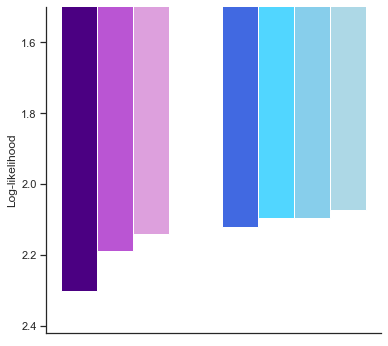

In [121]:
plt.figure(figsize=(6,6))
width = 0.2
b=6
c=4.5

(81/255, 214/255, 255/255)
plt.gca().invert_yaxis()
# plt.bar(width*1,np.mean(nhb_ru_c)/150,width=width,color='dimgray')
plt.bar(width*(1),(v_bic)/(150*62),width=width,color='indigo')
plt.bar(width*(2),(ve_bic)/(150*62),width=width,color='mediumorchid')
plt.bar(width*(3),(vep_bic)/(150*62),width=width,color='plum')

plt.bar(width*(c+1),(glm_v_bic)/(150*62),width=width,color='royalblue')
plt.bar(width*(c+2),(glm_e_bic)/(150*62),width=width,color=(81/255, 214/255, 255/255))
plt.bar(width*(c+3),(glm_p_bic)/(150*62),width=width,color='skyblue')
plt.bar(width*(c+4),(glm_vep_bic)/(150*62),width=width,color='lightblue')
# plt.bar(width*(c+5),np.mean(nhb_glm_ru_c_vep)/150,width=width,color='lightcyan',label='GLM:DUP')
# plt.yticks([-0.8,-0.85,-0.9,-0.95,-1])
plt.ylim(2.42,1.5)
plt.xticks([])
plt.ylabel('Log-likelihood')
sns.set(style='ticks')
sns.despine()
plt.show()

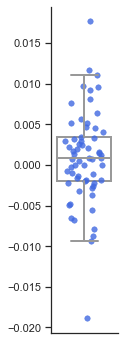

In [102]:
x = (np.random.random((62))-np.ones((62))*0.5)*0.6
plt.figure(figsize=(1.2,6))
sns.boxplot(data=df_glm_vep["beta_a"],linewidth=2,fliersize=0,color='white')
plt.scatter(x,df_glm_vep["beta_a"],s=30,color='royalblue',linewidths=0.5,alpha=0.8)
# plt.yticks([-3,-2,-1,0,1,2])
plt.xticks([])
# plt.ylim([-4,2])
sns.set(style='ticks')
sns.despine()

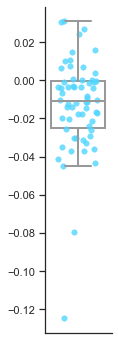

In [103]:
x = (np.random.random((62))-np.ones((62))*0.5)*0.6
plt.figure(figsize=(1.2,6))
sns.boxplot(data=df_glm_vep["phi_a"],linewidth=2,fliersize=0,color='white')
plt.scatter(x,df_glm_vep["phi_a"],s=30,color=(81/255, 214/255, 255/255),linewidths=0.5,alpha=0.8)
# plt.yticks([-3,-2,-1,0,1,2])
plt.xticks([])
# plt.ylim([-4,2])
sns.set(style='ticks')
sns.despine()

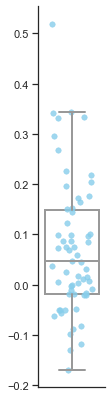

In [105]:
x = (np.random.random((62))-np.ones((62))*0.5)*0.6
plt.figure(figsize=(1.2,7))
sns.boxplot(data=df_glm_vep["persev_a"],linewidth=2,fliersize=0,color='white')
plt.scatter(x,df_glm_vep["persev_a"],s=30,color='skyblue',linewidths=0.5,alpha=0.8)
# plt.yticks([-3,-2,-1,0,1,2])
plt.xticks([])
# plt.ylim([-4,2])
sns.set(style='ticks')
sns.despine()

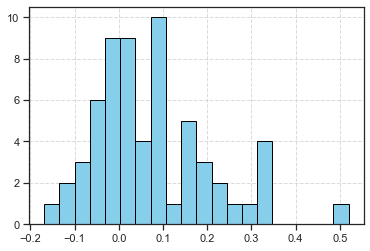

In [127]:
# 绘制直方图
plt.hist(df_glm_vep["persev_a"], bins=20, color='skyblue', edgecolor='black')  # bins控制分箱数
# plt.title("Histogram of Data Distribution")
# plt.xlabel("Value Range")
# plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7)  # 添加网格线

# 显示图像
plt.show()